In [1]:
# %matplotlib inline
from matplotlib import pyplot
from IPython import display
import time
import numpy as np
from copy import copy
import matplotlib.animation as anim
from IPython.display import HTML
from pathlib import Path
from enum import Enum

# Travelling Wave Simulation: Dampened Standing Waves

**Initial Variable Definitions**
$$A, b, k, \phi, \omega$$

**Derived Variables**
$$\lambda = \frac{2\pi}{k}$$
$$T = \frac{2\pi}{\omega}$$
$$f = 1/T$$
$$v = \frac{\omega}{k}$$

**Wave Function Composition**
As defined in the 'function' method:
$$y(x,t) = A\sin(kx \mp \omega t + \phi)$$

(all waves will just inherently use $\sin$ as the backbone)

In [2]:
class Operation(Enum):
    ADD  = 1
    SUB  = 2

class CompositeWave:
    def __init__(self):
        self.waves = []
        self.operations = []
    
    def __add__(self, other):
        if type(other) is SimpleWave:
            self.waves.append(other)
            self.operations.append(Operation.ADD)
        if type(other) is CompositeWave:
            self.waves.extend(other.waves)
            self.operations.extend(other.operations)
    
    def __sub__(self, other):
        if type(other) is SimpleWave:
            self.waves.append(other)
            self.operations.append(Operation.SUB)
        
    def __call__(self, x, t):
        total = 0
        for i in range(len(self.waves)):
            match self.operations[i]:
                case Operation.ADD:
                    total += self.waves[i](x,t)
                case Operation.SUB:
                    total -= self.waves[i](x,t)
        return total
                    
    def __str__(self):
        string = "CompositeWave(\n"
        for i in range(len(self.waves)):
            string += str(self.operations[i]) + "\n"
            string += str(self.waves[i]) + "\n"
        string += ")\n"
        return string

In [3]:
class Direction(Enum):
    RIGHT = -1
    LEFT = 1

class SimpleWave:
    def __init__(self, initial_amplitude, 
                 wave_number, angular_frequency, phase_shift, direction):
        self.initial_amplitude = initial_amplitude
        self.wave_number = wave_number
        self.angular_frequency = angular_frequency
        self.phase_shift = phase_shift
        
        self.direction = direction
        
        self.wavelength = (2 * np.pi) / wave_number
        self.period = (2 * np.pi) / angular_frequency
        self.frequency = 1 / self.period
        self.wave_speed = self.angular_frequency / self.wave_number
        
    def __str__(self):
        return (f'SimpleWave(\n' +
               f'\tinitial_amplitude={self.initial_amplitude},\n' + 
               f'\twave_number={self.wave_number}\n' +
               f'\tangular_frequency={self.angular_frequency}\n' +
               f'\tphase_shift={self.phase_shift}\n' +
               f'\tdirection={str(self.direction)}\n' +
               f'\twavelength={self.wavelength}\n' +
               f'\tperiod={self.period}\n' +
               f'\tfrequency={self.frequency}\n' +
               f'\twave_speed={self.wave_speed}\n)\n')
        
    def __call__(self, x, t):
        return self.initial_amplitude * np.sin(self.wave_number * x + 
                                               self.direction.value * self.angular_frequency * t +
                                               self.phase_shift)

    def __add__(self, other):
        if type(other) is CompositeWave:
            return other.__add__(self)
        if type(other) is SimpleWave:
            wave_sum = CompositeWave()
            wave_sum.__add__(self)
            wave_sum.__add__(other)
            return wave_sum
        else:
            return None
        
    def __sub__(self, other):
        if type(other) is CompositeWave:
            return other.__subtract__(self)
        if type(other) is SimpleWave:
            wave_sum = CompositeWave()
            wave_sum.__add__(self)
            wave_sum.__sub__(other)
            return wave_sum
        else:
            return None
        
    def convert_to_composite(self):
        composite = CompositeWave() 
        composite + self
        return composite

### Wave Definitions

In [4]:
right_wave = SimpleWave(initial_amplitude = 1,
                  wave_number = 1,
                  angular_frequency = 10,
                  phase_shift = 0,
                  direction = Direction.RIGHT)

left_wave = copy(right_wave)
left_wave.direction = Direction.LEFT

standing_wave = right_wave + left_wave 

print(right_wave.wave_speed)

10.0


In [5]:
MAX = 100 # x and t
FRAMES = 1000

class GraphType(Enum):
    HISTORY=0  # Fixed distance
    SNAPSHOT=1 # Fixed time

def plot_wave(wave, graph_type=GraphType.SNAPSHOT):
    xvalues = np.linspace(0, MAX, FRAMES)
    tvalues = np.linspace(0, MAX, FRAMES) 
    
    for frame in range(FRAMES):
        # set the range of plots as appropriate based on above choices of constants
        pyplot.figure(figsize=(10,3))
        pyplot.title(f'Frame {frame+1}/{FRAMES} - $t$={round(tvalues[frame], 2)} s')
        
        if type(wave) is SimpleWave:
            if graph_type == GraphType.SNAPSHOT:
                # show 4 wavelengths worth of length
                pyplot.xlim(0, wave.wavelength * 4)
            
            if graph_type == GraphType.HISTORY:
                # show a 30 second width from the current frame
                pyplot.xlim(max(tvalues[frame]-30,0), tvalues[frame]+30)
            
            pyplot.yticks((-wave.initial_amplitude, 0, wave.initial_amplitude))
            
        pyplot.ylabel('Displacement (m)')
        match graph_type:
            # Plotting snapshot graph
            case GraphType.SNAPSHOT:
                pyplot.xlabel('x (m)')
                pyplot.plot(xvalues, wave(xvalues, tvalues[frame]))
            # Plotting history graph
            case GraphType.HISTORY:
                pyplot.xlabel('t (s)')
                pyplot.plot(tvalues, wave(xvalues[frame], tvalues))
        
        # Animation commands
        display.clear_output(wait=True) 
        display.display(pyplot.gcf())
        time.sleep(0.05)
        pyplot.close()

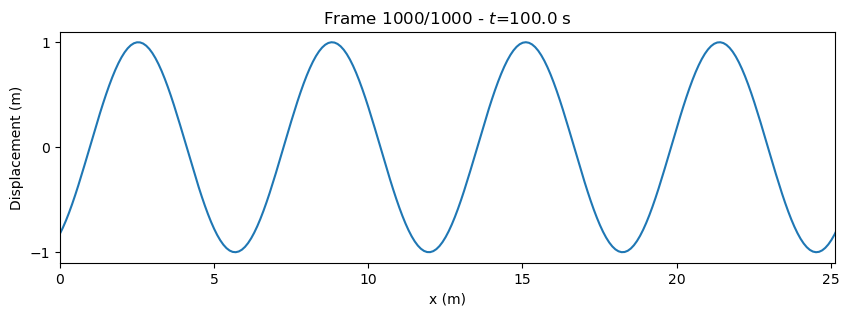

In [6]:
plot_wave(right_wave, graph_type=GraphType.SNAPSHOT)
# plot_wave(left_wave)
# plot_wave(standing_wave)